# Unsupervised Segmentation of DAPI dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import genus as gn
import numpy
from genus.util_data import  DataloaderWithLoad, ConditionalRandomCrop, DatasetInMemory
from genus.util import linear_interpolation, append_to_dict, ckpt2file, load_json_as_dict, load_obj
from genus.util_vis import show_batch
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from functools import partial

### Read the config file 

In [5]:
dataset_file = "/Users/ldalessi/REPOS/genus/notebooks/example_data/DAPI/dapi_downsampled.tif"
config_file = "/Users/ldalessi/REPOS/genus/notebooks/config_dapi.json"
config = load_json_as_dict(config_file)

### Open and Visualize the input image

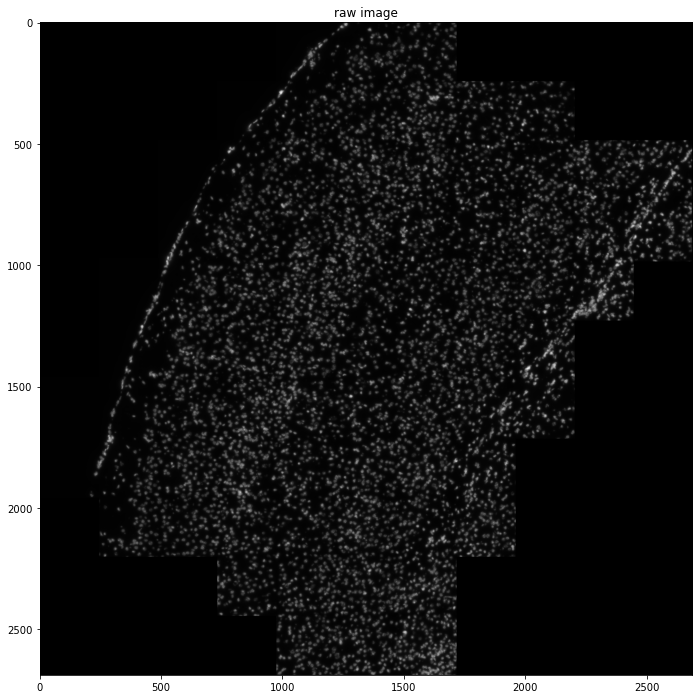

In [6]:
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None

pilfile = PIL.Image.open(dataset_file)
img_np = numpy.array(pilfile)

fig, axs = plt.subplots(ncols=1, figsize=(12,12))
axs.imshow(img_np, cmap='gray')
_ = axs.set_title("raw image")

### Obtain the Region of Interest (ROI) by simple thresholding

This image was collected by tiling a biological tissue with multiple Field of Views (FOVs). Therefore the Region of Interest has an irregular shape.

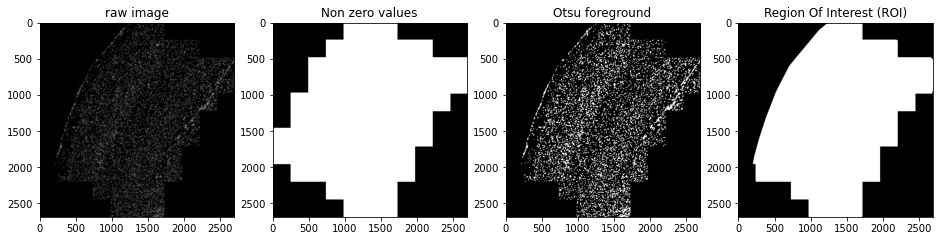

In [7]:
import skimage.filters
import skimage.morphology

image_thresh = skimage.filters.threshold_otsu(img_np)
roi_mask_np = skimage.morphology.convex_hull_image((img_np > image_thresh)) * (img_np > 1E-5)

fig, axs = plt.subplots(ncols=4, figsize=(16,16))
axs[0].imshow(img_np, cmap='gray')
axs[1].imshow(img_np > 0.0, cmap='gray')
axs[2].imshow(img_np > image_thresh, cmap='gray')
axs[3].imshow(roi_mask_np, cmap='gray')
_ = axs[0].set_title("raw image")
_ = axs[1].set_title("Non zero values")
_ = axs[2].set_title("Otsu foreground")
_ = axs[3].set_title("Region Of Interest (ROI)")

### Do some contrast enhancement

In [8]:
# Compute the quantile based on the Otsu foreground component
ql, qr = numpy.percentile(img_np[img_np > image_thresh].flatten(), q=(0, 100))  

# Rescale the intensities in (0,1)
img_np_rescaled = skimage.exposure.rescale_intensity(img_np, in_range=(ql, qr), out_range=(0.0, 1.0)) 

# Do intensity equalization
img_np_enhanced = skimage.exposure.equalize_adapthist(img_np_rescaled, kernel_size=160, clip_limit=0.03)

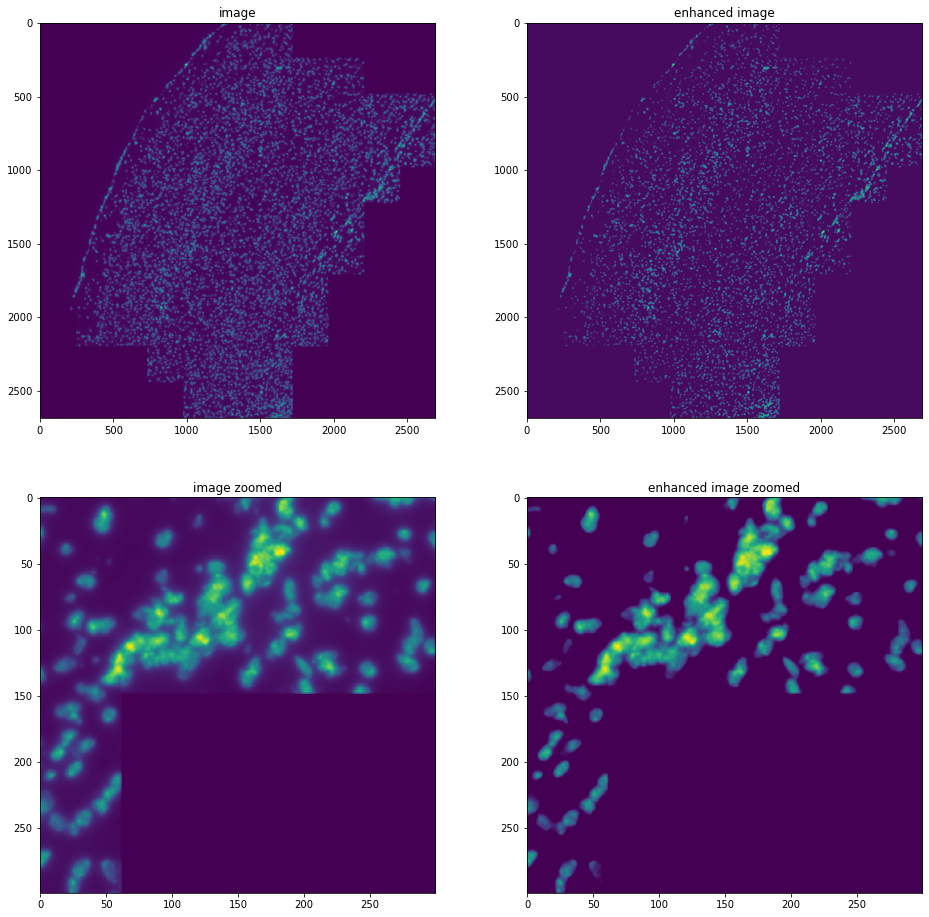

In [9]:
ix, iy, delta = 1080, 2140, 300
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16,16))
axs[0,0].imshow(img_np)
axs[0,1].imshow(img_np_enhanced)
axs[1,0].imshow(img_np[ix:ix+delta,iy:iy+delta])
axs[1,1].imshow(img_np_enhanced[ix:ix+delta,iy:iy+delta])

_ = axs[0,0].set_title("image")
_ = axs[0,1].set_title("enhanced image")
_ = axs[1,0].set_title("image zoomed")
_ = axs[1,1].set_title("enhanced image zoomed")

### Create the dataset 

In [10]:
img_torch = torch.from_numpy(img_np_enhanced)[None,None].float()
roi_mask_torch = torch.from_numpy(roi_mask_np)[None,None].bool()

In [15]:
BATCH_SIZE = config["simulation"]["batch_size"]
CROP_SIZE = config["input_image"]["size_image_patch"]
N_TEST = 3*BATCH_SIZE
N_TRAIN = BATCH_SIZE

conditional_crop_test = ConditionalRandomCrop(size=CROP_SIZE, n_crops_per_image=N_TEST, min_roi_fraction=0.9)
conditional_crop_train = ConditionalRandomCrop(size=CROP_SIZE, n_crops_per_image=N_TRAIN, min_roi_fraction=0.9)

In [27]:
# The test_dataset is built creating N_TEST random crops from the image
test_dataset = DatasetInMemory(x=conditional_crop_test(img=img_torch, roi_mask=roi_mask_torch))

print("test_dataset shape ->",test_dataset.x.shape)

dataset shape -> torch.Size([384, 1, 80, 80])


In [31]:
# The train_dataset consist of a single large image. During training random crops will be generated on the fly
train_dataset = DatasetInMemory(x=img_torch,
                                x_roi=roi_mask_torch,
                                x_transform=conditional_crop_train)
# the single (large) image in the dataset replicated N_TRAIN times (without memory footprint)
# to keep indexing consistent.
print("train_dataset shape ->",train_dataset.x.shape)  

train_dataset shape -> torch.Size([128, 1, 2688, 2688])


### Create the dataloader as usual

In [32]:
test_loader = DataloaderWithLoad(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataloaderWithLoad(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

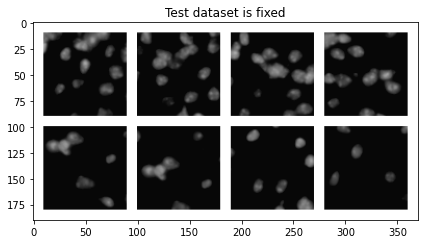

In [18]:
img, y, index = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test dataset is fixed")

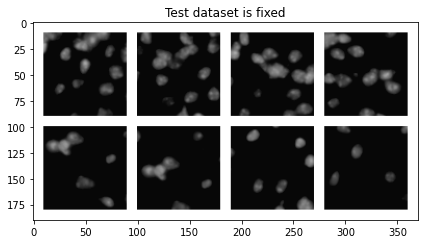

In [19]:
img, y, index = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test dataset is fixed")

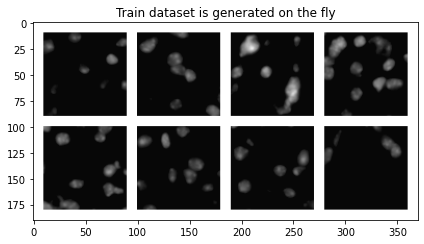

In [20]:
img, y, index = train_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Train dataset is generated on the fly")

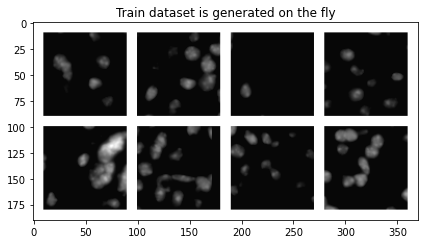

In [21]:
img, y, index = train_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Train dataset is generated on the fly")

### Instantiate the model, optimizer and scheduler

In [22]:
vae = CompositionalVae(config)
optimizer = instantiate_optimizer(model=vae, config_optimizer=config["optimizer"])

if config["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999

elif config["simulation"]["type"] == "resume":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', -1)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999

elif config["simulation"]["type"] == "pretrained":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if config["scheduler"]["is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, config_scheduler=config["scheduler"])
else:
    scheduler = None

### Training loop

In [23]:
TEST_FREQUENCY = config["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = config["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = config["simulation"]["MAX_EPOCHS"]

for epoch in range(NUM_EPOCHS+1):
    
    vae.annealing_factor = linear_interpolation(epoch,
                                                values=(1.0, 0.0),
                                                times=config["loss"]["annealing_times"])
    
    vae.train()
    train_metrics = process_one_epoch(model=vae,
                                      dataloader=train_loader,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      iom_threshold=config["architecture"]["nms_threshold_train"],
                                      verbose=(epoch == 0))
    
    with torch.no_grad():
        print("Train " + train_metrics.pretty_print(epoch))
        history_dict = append_to_dict(source=train_metrics,
                                      destination=history_dict,
                                      prefix_exclude="wrong_examples",
                                      prefix_to_add="train_")
        
        if (epoch % TEST_FREQUENCY) == 0:
            vae.eval()
            test_metrics = process_one_epoch(model=vae,
                                             dataloader=test_loader,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             iom_threshold=config["architecture"]["nms_threshold_test"],
                                             verbose=(epoch == 0))
            print("Test  "+test_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=test_metrics,
                                          destination=history_dict,
                                          prefix_exclude="wrong_examples",
                                          prefix_to_add="test_")
            
        if (epoch % CHECKPOINT_FREQUENCY == 0) and (epoch >= 20):
            ckpt = vae.create_ckpt(optimizer=optimizer,
                                   epoch=epoch,
                                   history_dict=history_dict)
            ckpt2file(ckpt=ckpt, path="last_ckpt_"+str(epoch))

i =   0 train_loss=9715.18945
Train [epoch    0] loss=9715.189, mse=87.479, mask_overlap=0.107,              bb_regression=0.000, fg_fraction_av=0.163, n_cell_av=0.000, lambda_mse=100.000,              lambda_ncell=1.000, lambda_fgfraction=1.000
i =   0 train_loss=9248.21777
i =   1 train_loss=9111.22266


KeyboardInterrupt: 

### Visualize the results (for example MSE)

In [ ]:
plt.imshow()